In [35]:
import sys

sys.path.append("../")

In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt


In [37]:
import requests
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


def to_dataframe(json_data):
    df = pd.DataFrame(json_data, columns=['OpenTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 'BaseAssetVolume', 'NbTrades', 'TakerBuyVol', 'TakerBuyBaseAssetVol', 'Ignore'])
    df.drop(columns=['CloseTime', 'BaseAssetVolume', 'NbTrades', 'TakerBuyVol', 'TakerBuyBaseAssetVol', 'Ignore'], inplace=True)
    df['OpenTime'] = pd.to_datetime(df['OpenTime'], unit='ms')
    df.set_index(keys=['OpenTime'], inplace=True)

    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype('float32')

    return df


def get_klines(base_url, symbol, interval='1m'):
    end_time = int(datetime.utcnow().timestamp() * 1000)
    url = f"{base_url}/klines?symbol={symbol}&limit=1000&interval={interval}&endTime={end_time}"

    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("GET", url, headers=headers)

    df = to_dataframe(response.json())
    return df


def get_futures_data(symbol, interval='1m'):
    # 
    return get_klines('https://fapi.binance.com/fapi/v1', symbol, interval=interval)



def get_coinm_data(symbol, interval='1m'):
    # 
    return get_klines('https://dapi.binance.com/dapi/v1', symbol, interval=interval)


def get_spot_data(symbol, interval='1m'):
    return get_klines('https://api.binance.com/api/v3', symbol, interval=interval)


In [38]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'SOL', 'LUNA', 'AVAX', 'DOT', 'DOGE', 'SHIB', 'UST', 'MATIC', 'CRO', 'WBTC', 'DAI', 'ATOM', 'LTC', 'LINK']
symbols = [f'{s}USDT' for s in symbols]

data = []

for symbol in symbols:
    df = get_futures_data(symbol=symbol, interval='5m')

    df.rename(columns={'Close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    data.append(np.log(df[symbol]))

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,SOLUSDT,LUNAUSDT,AVAXUSDT,DOTUSDT,DOGEUSDT,MATICUSDT,ATOMUSDT,LTCUSDT,LINKUSDT
OpenTime,,,,,,,,,,,,,,
2022-04-15 12:25:00,10.601117,8.014782,6.033014,-0.246540,-0.049821,4.621536,4.402846,4.354142,2.899001,-1.915216,0.327432,3.182958,4.704925,2.631673
2022-04-15 12:30:00,10.600432,8.013750,6.032342,-0.247821,-0.050767,4.619073,4.399879,4.352598,2.897678,-1.916099,0.327143,3.182295,4.705830,2.630593
2022-04-15 12:35:00,10.600597,8.013469,6.032486,-0.250643,-0.050662,4.618382,4.398896,4.352726,2.898726,-1.917867,0.327648,3.182004,4.705378,2.629728
2022-04-15 12:40:00,10.601256,8.014171,6.032966,-0.248333,-0.051083,4.619763,4.399952,4.352340,2.899497,-1.917255,0.328872,3.182958,4.706553,2.629800
2022-04-15 12:45:00,10.600059,8.012791,6.031454,-0.250772,-0.053506,4.617988,4.396977,4.349374,2.896906,-1.922780,0.326350,3.180135,4.705196,2.627635


In [39]:
df.tail()

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,SOLUSDT,LUNAUSDT,AVAXUSDT,DOTUSDT,DOGEUSDT,MATICUSDT,ATOMUSDT,LTCUSDT,LINKUSDT
OpenTime,,,,,,,,,,,,,,
2022-04-18 23:20:00,10.619083,8.027232,6.032895,-0.263054,-0.066033,4.628691,4.491755,4.354142,2.903891,-1.964899,0.350305,3.180758,4.712948,2.641697
2022-04-18 23:25:00,10.616810,8.024679,6.030685,-0.264096,-0.066888,4.625463,4.491486,4.351825,2.898836,-1.968043,0.348401,3.179261,4.711061,2.641697
2022-04-18 23:30:00,10.616761,8.024476,6.031334,-0.265529,-0.067209,4.625561,4.494227,4.351439,2.899717,-1.967685,0.348895,3.177345,4.710611,2.640199
2022-04-18 23:35:00,10.614647,8.023198,6.030469,-0.265921,-0.069029,4.622420,4.492360,4.349116,2.896796,-1.969261,0.349670,3.176010,4.709710,2.637771
2022-04-18 23:40:00,10.615017,8.023834,6.030974,-0.267226,-0.068814,4.622617,4.493412,4.350794,2.897568,-1.968759,0.351642,3.178012,4.710340,2.638629


In [40]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [41]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[200.04197562627206, -142.86295210773778]",BTCUSDT,ETHUSDT
1,"[65.95776793085341, -10.33232478291971]",ETHUSDT,LUNAUSDT
2,"[224.8636144100686, -189.6247172764275]",ETHUSDT,AVAXUSDT
3,"[198.5788753107532, -152.43805744832994]",ETHUSDT,ATOMUSDT
4,"[167.96553600733287, -164.258891532214]",SOLUSDT,AVAXUSDT


In [42]:
coint_df.to_csv('coint_df.csv')


In [43]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        hedge_ratio = coint_df.iloc[i]['hedge_ratio']
        _df = df.copy()
        spread = calculate_spread(_df, i, hedge_ratio)
            
        half_life = cal_half_life(spread)
        pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
        # print(i, pairs_name, 'is stationary with half life', half_life)
        # print(' ')
        data.append({
            'i': i,
            'pairs': pairs_name,
            'half_life': half_life
        })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

In [44]:
stationary_df

,i,pairs,half_life
4,4,"[SOLUSDT, AVAXUSDT]",98.814109
5,5,"[DOTUSDT, LTCUSDT]",2607.116335
2,2,"[ETHUSDT, AVAXUSDT]",20396.251159
1,1,"[ETHUSDT, LUNAUSDT]",38573.794649
3,3,"[ETHUSDT, ATOMUSDT]",38717.302737
0,0,"[BTCUSDT, ETHUSDT]",101166.932929


In [61]:
selected_row = stationary_df[stationary_df['i'] == 2]['i'].iloc[-1]
print(selected_row)
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(df, selected_row, hedge_ratio)
spread = spread.iloc[:1000]

2


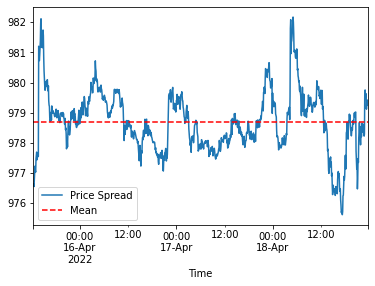

In [62]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [63]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

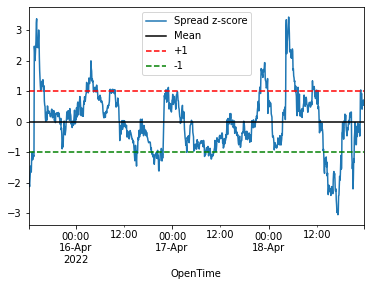

In [64]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])